In [7]:
import os
import sys
import copy
import time
import random
import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, FloatType, IntegerType
from pyspark.sql.functions import col, substring

# for creating pipelines and model
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

Initialize spark session.

In [8]:
import os
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, IntegerType, StructField, StructType
from time import time
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars xgboost4j-0.90.jar,xgboost4j-spark-0.90.jar pyspark-shell'

def init_spark():
    spark = SparkSession \
        .builder \
        .getOrCreate()
    return spark

spark = init_spark()

# Data Split

Load the preprocessed data after feature engineering and labelling.

In [9]:
feat_data = spark.read.parquet('../data/labeled_features3.parquet')
feat_data = feat_data.withColumn("age", feat_data.age.cast(DoubleType()))

def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(20,16))
    # Plot Searborn bar chart
    sn.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

feat_data = feat_data.withColumnRenamed("label_e", "label")
feat_data = feat_data.withColumn("machineID", feat_data.machineID.cast(IntegerType()))
feat_data = feat_data.withColumn("label", feat_data.label.cast(IntegerType()))
feat_data = feat_data.withColumn("model", substring("model", 6,1).cast(IntegerType())) #keep model
    
# highly imbalanced data
print(feat_data.count())
print(feat_data.groupby('label').count().show())
feat_data.limit(10).toPandas().head(10)

292142
+-----+------+
|label| count|
+-----+------+
|    1|  1396|
|    3|  1013|
|    4|  1502|
|    2|  1876|
|    0|286355|
+-----+------+

None


,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,...,error5sum_rollingmean_12,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label
0,2016-01-01 01:00:00,155.926136,508.873216,103.217517,44.404096,168.808851,459.669547,103.067957,41.409164,169.366028,...,0.0,579.0,534.0,474.0,459.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
1,2015-12-31 22:00:00,177.241489,443.717507,103.011478,37.057737,174.314186,450.696569,100.441772,40.051142,169.556059,...,0.0,579.0,534.0,474.0,459.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
2,2015-12-31 19:00:00,170.262559,444.910532,107.530806,40.707467,170.484633,457.562043,100.751848,41.019130,166.773586,...,0.0,579.0,534.0,474.0,459.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
3,2015-12-31 16:00:00,168.169328,453.981021,98.461255,43.418780,169.776971,456.909157,98.917461,40.899594,166.512359,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
4,2015-12-31 13:00:00,181.583369,460.177215,92.763549,39.020584,170.272706,453.480797,98.386310,40.507900,167.148002,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
5,2015-12-31 10:00:00,161.923275,471.179402,104.251783,40.929688,164.797932,446.889030,100.060783,41.448674,164.108382,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
6,2015-12-31 07:00:00,167.431912,442.298992,100.193256,40.229322,163.062540,442.763560,99.445755,41.622275,163.607945,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
7,2015-12-31 04:00:00,170.152267,440.267578,96.336650,41.852004,163.247748,445.304944,101.090962,42.385029,163.894898,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
8,2015-12-31 01:00:00,159.684275,433.810148,99.461441,42.783680,164.023299,447.469174,102.041216,42.653336,165.401512,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
9,2015-12-30 22:00:00,154.981705,454.677523,101.791672,41.624095,163.418831,448.430676,102.840632,42.795697,166.756664,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0


# XGB eXtreme Gradient Boosting

The data is very imbalanced. Most of the time there are no failures at all. We will tackle this by undersampling the majority class. After processing, we have in total 36 features and reduce the storage 5 times.

In [10]:
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold


split_date = "2015-09-30"
training = feat_data.filter(feat_data.dt_truncated < split_date)
testing = feat_data.filter(feat_data.dt_truncated >= split_date)
train_data = training.drop(*['dt_truncated', 'model_encoded', 'failure'])
test_data = testing.drop(*['dt_truncated', 'model_encoded', 'failure'])

train_data = train_data.sampleBy('label', fractions={0: 0.2, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}, seed=0).cache()
train_data.groupby('label').count().show()
test_data.groupby('label').count().show()

input_features = train_data.columns
input_features

# train_data.dtypes
# test_data.limit(10).toPandas().head(10)
# print(train_data.count())
# print(test_data.count())
train_data.limit(10).toPandas().head(10)

+-----+-----+
|label|count|
+-----+-----+
|    1| 1119|
|    3|  788|
|    4| 1167|
|    2| 1335|
|    0|42581|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    1|  277|
|    3|  225|
|    4|  335|
|    2|  541|
|    0|73131|
+-----+-----+



,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,vibration_rollingmean_24,...,error3sum_rollingmean_12,error4sum_rollingmean_12,error5sum_rollingmean_12,comp1sum,comp2sum,comp3sum,comp4sum,model,age,label
0,169.169783,455.595417,100.178579,41.324040,174.044499,454.561801,103.025570,38.749919,171.024937,39.081260,...,0.0,0.0,0.0,485.0,440.0,380.0,365.0,4,3.0,0
1,171.316836,425.681136,100.889078,40.478163,171.957313,440.263013,99.484712,39.798709,169.223500,40.001099,...,0.0,0.0,0.0,485.0,440.0,380.0,365.0,4,3.0,0
2,176.274310,459.059512,103.787701,41.758544,172.176675,463.524163,100.395050,39.403771,167.480009,40.616964,...,0.0,0.0,0.0,484.0,439.0,379.0,364.0,4,3.0,0
3,163.618228,461.368419,99.667388,43.726015,170.253113,453.318621,97.745079,41.180658,172.367575,40.861587,...,0.0,0.0,0.0,483.0,438.0,378.0,363.0,4,3.0,0
4,173.190718,442.833353,102.983993,41.802946,174.482037,452.469914,102.897443,40.542516,173.075077,40.687738,...,0.0,0.0,0.0,482.0,437.0,377.0,362.0,4,3.0,0
5,167.692131,428.198417,92.621861,41.198271,172.700729,441.448071,100.790087,39.056566,171.675780,39.091751,...,0.0,0.0,0.0,482.0,437.0,377.0,362.0,4,3.0,0
6,184.404970,451.297604,106.958278,36.861616,171.811618,431.689183,99.463185,38.454332,173.654132,40.116839,...,0.0,0.0,0.0,481.0,436.0,376.0,361.0,4,3.0,0
7,171.632365,454.929028,103.230522,41.150763,168.983269,449.838722,103.252646,39.113927,168.435069,40.408118,...,0.0,0.0,0.0,480.0,435.0,375.0,360.0,4,3.0,0
8,166.754214,459.033327,97.204117,39.483607,171.409119,477.931714,96.523387,39.489096,170.008706,39.632582,...,0.0,0.0,0.0,479.0,434.0,374.0,359.0,4,3.0,0
9,170.798912,490.034683,105.221796,41.805198,173.279357,474.144651,94.403866,39.761605,170.595088,39.270802,...,0.0,0.0,0.0,478.0,433.0,373.0,358.0,4,3.0,0


Covert data to native XGB format. Train XGBClassifier.

In [11]:
train_ = train_data.toPandas()
test_ = test_data.toPandas()

X_train = train_.iloc[:,:-1]
y_train = train_.iloc[:,-1]
X_test = test_.iloc[:,:-1]
y_test = test_.iloc[:,-1]

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

xgb_clf = xgb.XGBClassifier(max_depth=100, n_estimators=200, grow_policy='lossguide',
                            objective='multi:softmax', booster='gbtree', num_classes=5,
                            learning_rate=0.45, reg_lambda=0.9, n_jobs=2, random_state=0)

model = xgb_clf.fit(X_train, y_train)

Apply early stopping to prevent overfitting

In [71]:
from xgboost import XGBRegressor, XGBClassifier

train_ = train_data.toPandas()
test_ = test_data.toPandas()

X_train = train_.iloc[:,:-1]
y_train = train_.iloc[:,-1]
X_val_test = test_.iloc[:,:-1]
y_val_test = test_.iloc[:,-1]

split_mask = np.random.rand(len(X_val_test)) < 0.5
X_val = X_val_test[split_mask]
y_val = y_val_test[split_mask]
X_test = X_val_test[~split_mask]
y_test = y_val_test[~split_mask]
print(len(X_train), len(y_train), len(X_val), len(y_val))

xgb_clf = xgb.XGBClassifier(max_depth=100, n_estimators=100, grow_policy='lossguide',
                            objective='multi:softmax', booster='gbtree', num_classes=5,
                            learning_rate=0.1, reg_lambda=0.9, n_jobs=2, random_state=0)

model = xgb_clf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_val, y_val)], 
    early_stopping_rounds=10, 
    eval_metric="mlogloss"
)

54433 54433 9380 9380
[0]	validation_0-mlogloss:1.42137
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.29258
[2]	validation_0-mlogloss:1.17212
[3]	validation_0-mlogloss:1.08166
[4]	validation_0-mlogloss:1.00796
[5]	validation_0-mlogloss:0.943736
[6]	validation_0-mlogloss:0.884578
[7]	validation_0-mlogloss:0.836102
[8]	validation_0-mlogloss:0.792538
[9]	validation_0-mlogloss:0.752616
[10]	validation_0-mlogloss:0.714026
[11]	validation_0-mlogloss:0.679893
[12]	validation_0-mlogloss:0.650899
[13]	validation_0-mlogloss:0.623064
[14]	validation_0-mlogloss:0.597754
[15]	validation_0-mlogloss:0.575085
[16]	validation_0-mlogloss:0.554547
[17]	validation_0-mlogloss:0.533502
[18]	validation_0-mlogloss:0.514309
[19]	validation_0-mlogloss:0.498848
[20]	validation_0-mlogloss:0.482395
[21]	validation_0-mlogloss:0.468909
[22]	validation_0-mlogloss:0.456719
[23]	validation_0-mlogloss:0.445628
[24]	validation_0-mlogloss:0.434074
[25]	validation_0-mloglo

In [12]:
# preds = xgb_clf.predict(dtest)
# Predictions returns as probabilities
# y_pred = [round(value) for value in preds]
# Predictions returns as classes
# y_pred = np.array(y_pred).astype(int) 
y_pred = xgb_clf.predict(X_test) 
y_true = y_test # True values, dataframe format

print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

Accuracy:  0.999


In [13]:
l = y_pred.tolist()
prediction = testing.repartition(1).withColumn('prediction', 
    F.udf(lambda x: l[x])(F.monotonically_increasing_id()))
prediction.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    3|         3|  209|
|    3|         1|   13|
|    4|         3|    1|
|    2|         4|    3|
|    1|         0|    2|
|    3|         4|    1|
|    3|         2|    1|
|    2|         2|  537|
|    1|         3|    2|
|    3|         0|    1|
|    0|         1|   23|
|    0|         2|    1|
|    0|         0|73093|
|    2|         1|    1|
|    1|         1|  268|
|    0|         3|    6|
|    0|         4|    8|
|    1|         4|    5|
|    4|         4|  331|
|    4|         1|    3|
+-----+----------+-----+



### Evaluation

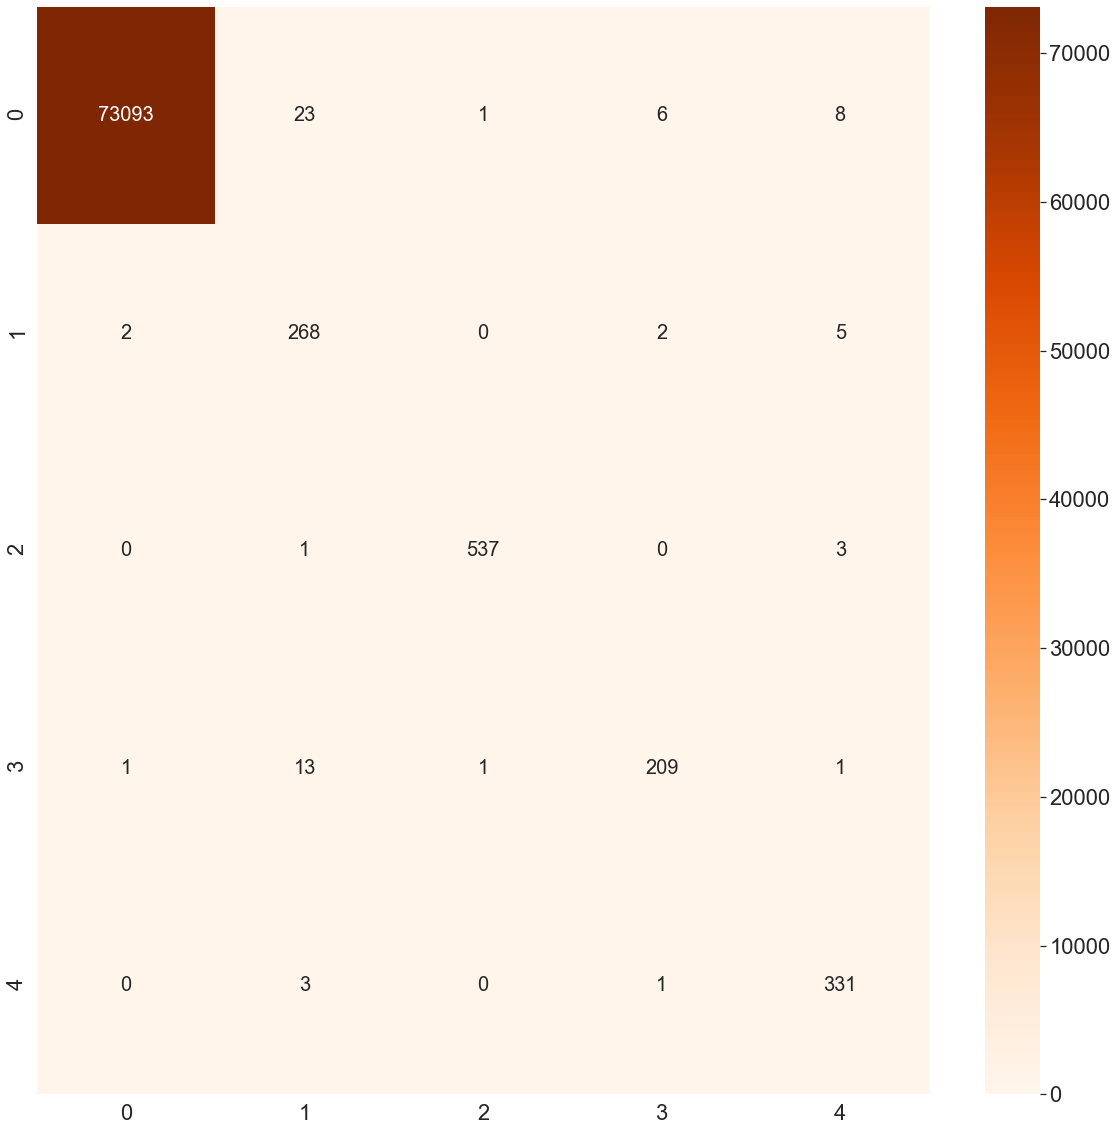

              precision    recall  f1-score   support

           0      1.000     0.999     1.000     73131
           1      0.870     0.968     0.916       277
           2      0.996     0.993     0.994       541
           3      0.959     0.929     0.944       225
           4      0.951     0.988     0.969       335

    accuracy                          0.999     74509
   macro avg      0.955     0.975     0.965     74509
weighted avg      0.999     0.999     0.999     74509



In [14]:
from sklearn import metrics
import seaborn as sn

# Print the confusion matrix
confusion = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (20,20))
sn.set(font_scale=2) # for label size
sn.heatmap(confusion, annot=True, annot_kws={"size": 20}, cmap='Oranges', fmt='d') # font size
plt.show()

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

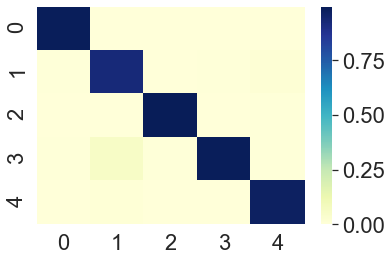

In [18]:
confusion = confusion.astype('float') / confusion.sum(axis=0)[:, np.newaxis]
f = sn.heatmap(confusion, cmap="YlGnBu")

Analyze the trained model to find important feature

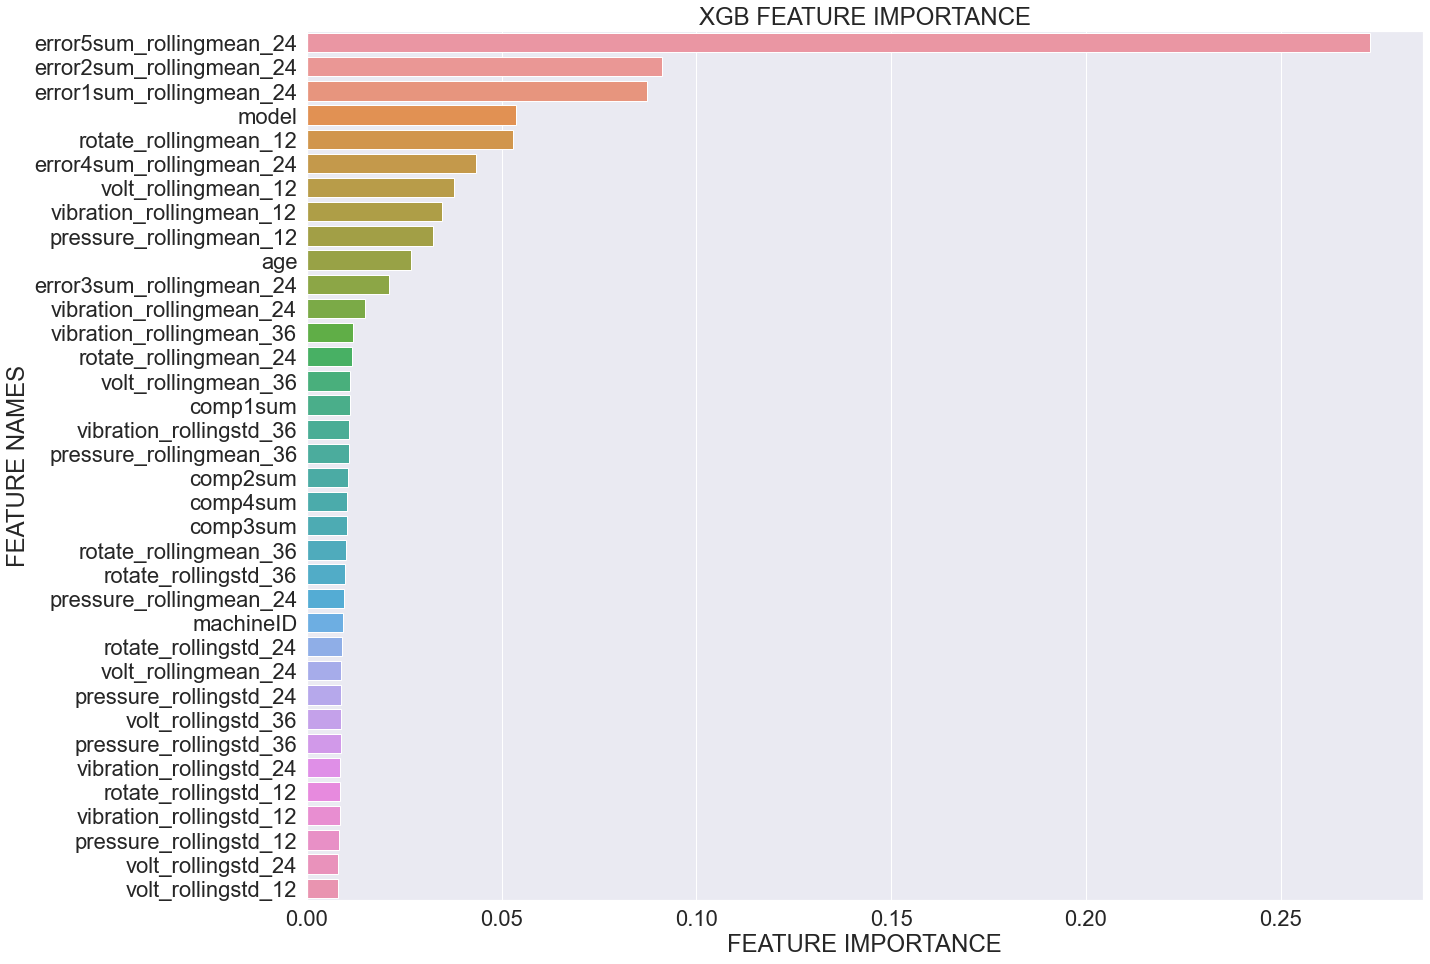

In [62]:
#print(model.feature_importances_)
plot_feature_importance(model.feature_importances_, input_features[:-1], 'XGB')

### Tuning and validation

In [52]:
train_ = train_data.toPandas()
test_ = test_data.toPandas()

X_train = train_.iloc[:,:-1]
y_train = train_.iloc[:,-1]
X_test = test_.iloc[:,:-1]
y_test = test_.iloc[:,-1]

param_dict = {'learning_rate': np.arange(0.0, 0.55, 0.025),
              'max_depth': np.arange(10, 105, 5),
              'n_estimators': [50, 75, 100, 125, 150],
              'grow_policy':['depthwise', 'lossguide'],
              'objective': ['multi:softmax'],
              'booster': ['gbtree'],
              'num_classes': [5],
              'subsample': np.arange(0.8, 1.05, 0.05),
              'reg_lambda': np.arange(0.5, 2.05, 0.1)}

xgb_clf = xgb.XGBClassifier()
# scoring = 'recall_micro'
# scoring = 'balanced_accuracy'
# scoring = 'average_precision'
# scoring = 'roc_auc_ovo'
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=0)
clf_random = RandomizedSearchCV(estimator = xgb_clf, param_distributions = param_dict, 
                                n_iter = 50, scoring = 'f1_macro', cv = cv,
                                n_jobs = 4, random_state = 0, verbose = 1)

clf_random.fit(X_train, y_train)
model = clf_random.best_estimator_
print("Best parameter: ", clf_random.best_params_)
print("Best score: ", clf_random.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 32.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 33.2min finished


Best parameter:  {'subsample': 1.0000000000000002, 'reg_lambda': 0.8999999999999999, 'objective': 'multi:softmax', 'num_classes': 5, 'n_estimators': 150, 'max_depth': 90, 'learning_rate': 0.45, 'grow_policy': 'lossguide', 'booster': 'gbtree'}
Best score:  0.7070863116196531


### Spark Streaming

Define function process the dataflow

In [6]:
test_data.cache();

def get_prediction(stream_text):
    try:
    # filter the tweets whose length is greater than 0
        stream_text = stream_text.filter(lambda x: len(x) > 0)
        test_ = test_data.toPandas()
        X_test = test_.iloc[:,:-1]
    # create a dataframe with column name 'tweet' and each row will contain the tweet
        arr = stream_text.collect()[0].split(',')
        arr = [float(item) for item in arr]
        rowPd = pd.Series(arr, index=X_test.columns)
    # create a spark dataframe
        X_test = X_test.append(rowPd, ignore_index=True)
        item = X_test.iloc[[-1]]
    # transform the data using the pipeline and get the predicted sentiment
        prediction = model.predict(item) 
        print('prediction: ', prediction)
    except : 
        print('No data')
        
#print(X_test[X_test.index.isin([0])].to_csv(index=False,header=False))
#print(X_test[X_test.index.isin([42])].to_csv(index=False,header=False))
#print(X_test.iloc[42]) #print(X_test.iloc[[42]])
#print(X_test.columns)
#test = model.predict(X_test.iloc[[42]])

Establish communication and wait for dataflow

In [64]:
from pyspark.streaming import StreamingContext
from pyspark import SparkContext

# initialize the streaming context 
sc = SparkContext.getOrCreate()
ssc = StreamingContext(sc, batchDuration= 3)

# Create a DStream that will connect to hostname:port, like localhost:9991, nc -L -p 9991
lines = ssc.socketTextStream("localhost", 9981)

# split the tweet text by a keyword '_' so that we can identify which set of words is from a single item
words = lines.flatMap(lambda line : line.split('_'))

# get the predicted sentiments for the tweets received
words.foreachRDD(get_prediction)

# Start the computation
ssc.start()             

# Wait for the computation to terminate
ssc.awaitTerminationOrTimeout(60)
ssc.stop(stopSparkContext = False)

No data
No data
prediction:  [0]
No data
No data
No data
No data
No data
prediction:  [2]
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
